('FIle name', 'Audio6.wav')
('Swipe running', 'E:\\Music_Retrieval\\Project\\audios\\Audio6.wav')
Features extracted
findFeatures running
Read frequencies of audio and find MIDI notes and pattern
('Pattern:', 'udSSSSSSSSSSdSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSuSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSuSSSSSSSSSSSSSSSSSSSSSSSSSSSSSdSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSdSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSdSSSSuSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSdSSSSSSSSSSSSSSSuSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSuSSSSSSSSSSSSSSSSSSSSSSSSSSSSuSSSSS

C:\Users\Disha\Anaconda2\lib\site-packages\ipykernel\__main__.py:120: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Disha\Anaconda2\lib\site-packages\ipykernel\__main__.py:122: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


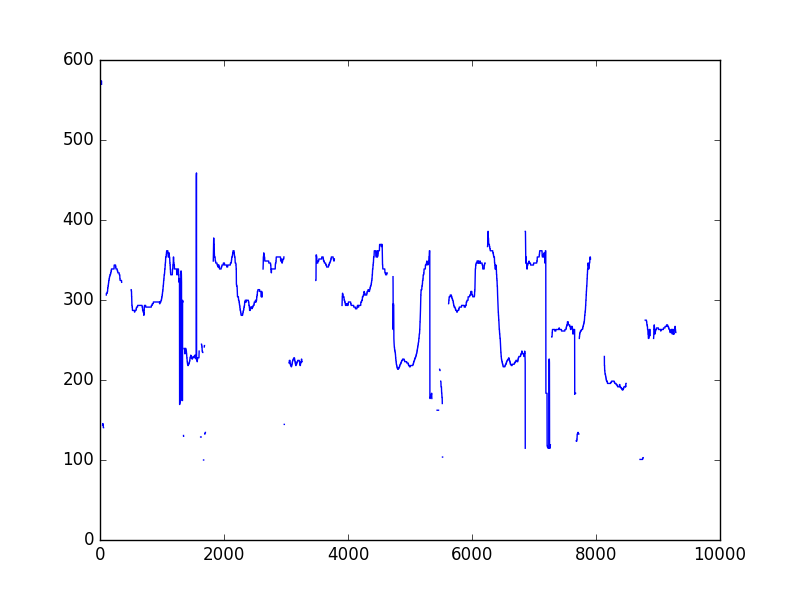

In [1]:
# RECORD WORKING

import pyaudio, wave, sys
import sqlite3 as lite
import math
import sqlite3 as lite
import os.path
from os import listdir, getcwd
from IPython.display import display, Image
import json
from pylab import *
import matplotlib.mlab
import matplotlib.pyplot as plt
from bqplot import pyplot as pl
import wave
import numpy as np
from numpy import matlib
from scipy.io import wavfile
from scipy import signal
from scipy import interpolate

DB = 'E:\\Music_Retrieval\\Project\\audios\\MIR_QBH.db'
path='E:\\Music_Retrieval\\Project\\audios';
songNo = 6;
audio="audio"+str(songNo)+".png";
connection = lite.connect(DB)

WAVE_OUTPUT_FILENAME = 'E:\\Music_Retrieval\\Project\\audios\\Audio'+str(songNo)+'.wav'


base=os.path.basename(WAVE_OUTPUT_FILENAME)
afile, ext = os.path.splitext(base)    
filePath=WAVE_OUTPUT_FILENAME;
fileName=afile+ext;
print ("FIle name",afile+ext) 

def recordAudio():
    
    CHUNK = 8192
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    RECORD_SECONDS = 10


   
    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                   channels = CHANNELS,
                   rate = RATE,
                   input = True,
                   input_device_index = 0,
                   frames_per_buffer = CHUNK)

    print("* recording")

    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("* done recording")

    #record stage
    #with connection:
    #    cursor = connection.cursor() 
    #    cursor.execute("INSERT INTO hummedFeature (id,queryTone ) VALUES(?,?);",(1,WAVE_OUTPUT_FILENAME))

    stream.stop_stream()    # "Stop Audio Recording
    stream.close()          # "Close Audio Recording
    p.terminate()           # "Audio System Close

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    connection.close()
#recordAudio();
    
    
#********************SWIPE-pitch extraction**************************

def swipep(x, fs, plim, dt, sTHR):
    if not plim:
        plim = [30 , 5000]
    if not dt:
        dt = 0.01
    dlog2p = 1.0/96.0;
    dERBs = 0.1;
    if not sTHR:
        sTHR = -float('Inf')
    
    t = np.arange(0, len(x)/float(fs), dt )    #Times
    
    dc = 4;   # Hop size (in cycles)
    
    K = 2;   # Parameter k for Hann window
    # Define pitch candidates
    log2pc = np.arange( np.log2(plim[0]), np.log2(plim[len(plim)-1]) ,dlog2p );
    pc = np.power(2, log2pc);

    S = np.zeros( shape=(len(pc), len(t)) );   # Pitch strength matrix
    
    # Determine P2-WSs
    logWs = np.round_( np.log2( np.multiply(4*K, (np.divide(float(fs), plim) ))));
    ws = np.power(2, np.arange( logWs[1-1], logWs[2-1]-1, -1 ));   # P2-WSs
    pO = 4*K * np.divide(fs, ws);   # Optimal pitches for P2-WSs
    # Determine window sizes used by each pitch candidate
    d = 1 + log2pc - np.log2( np.multiply(4*K, (np.divide(fs, ws[1-1] ))));
    # Create ERBs spaced frequencies (in Hertz)
    fERBs = erbs2hz( np.arange( hz2erbs(pc[1-1]/4), hz2erbs(fs/2), dERBs));
    
    for i in range(0, len(ws)):
        dn = round( dc * fs / pO[i] ); # Hop size (in samples)
        # Zero pad signal
        will = np.zeros( (ws[i]/2, 1) );
        learn = np.reshape(x, -1, order='F')[:, np.newaxis];
        mir = np.zeros( (dn + ws[i]/2, 1) );
        xzp = np.vstack((will, learn, mir));
        xk = np.reshape(xzp, len(xzp), order='F');
        # Compute spectrum
        w = np.hanning( ws[i] ); # Hann window
        o = max( 0, round( ws[i] - dn ) ); # Window overlap
        [ X, f, ti, im] = plt.specgram(xk, NFFT=int(ws[i]), Fs=fs, window=w, noverlap=int(o));
          
        # Interpolate at equidistant ERBs steps
        f = np.array(f);
        X1 = np.transpose(X);
        
        ip = interpolate.interp1d( f, X1, kind='linear')(fERBs[:, np.newaxis]);
        interpol = ip.transpose(2,0,1).reshape(-1,ip.shape[1]);
        interpol1 = np.transpose(interpol);
        M = np.maximum( 0, interpol1 ); # Magnitude
        L = np.sqrt( M ); # Loudness
        # Select candidates that use this window size
        if i==(len(ws)-1):
            j = find(d - (i+1) > -1);  
            k = find(d[j] - (i+1) < 0); 
        elif i==0:
            j = find(d - (i+1) < 1);
            k = find(d[j] - (i+1) > 0);
        else:
            j = find(abs(d - (i+1)) < 1); 
            k1 = np.arange(0,len(j)); # transpose added by KG
            k = np.transpose(k1);
        Si = pitchStrengthAllCandidates( fERBs, L, pc[j] );
        # Interpolate at desired times
        if Si.shape[1] > 1:
            tf=[];
            tf = ti.tolist();
            tf.insert(0, 0);
            del tf[-1];
            ti = np.asarray(tf);
            Si = interpolate.interp1d( ti, Si, 'linear', fill_value=nan)(t);
        else:
            Si = matlib.repmat( float('NaN'), len(Si), len(t) );
        lambda1 = d[j[k]] - (i+1);
        mu = ones( size(j) );
        mu[k] = 1 - abs( lambda1 );
        S[j,:] = S[j,:] + np.multiply(((np.kron(np.ones((Si.shape[1], 1)), mu)).transpose()), Si);
        
    # Fine-tune the pitch using parabolic interpolation
    p = np.empty((Si.shape[1],))
    p[:] = np.NAN;
    s = np.empty((Si.shape[1],))
    s[:] = np.NAN;
    for j in range(0, Si.shape[1]):
        s[j] = ( S[:,j] ).max(0);
        i =  np.argmax(S[:,j]);
        if s[j] < sTHR: continue
        if i==0:
             p[j]=pc[0];
        elif i==len(pc)-1:
            p[j]=pc[0]; 
        else:
            I = np.arange(i-1,i+2);
            tc = np.divide(1, pc[I]);
            ntc = ( (tc/tc[1]) - 1 ) * 2*pi;
            c = polyfit( ntc, (S[I,j]), 2 );
            ftc = np.divide(1, np.power(2, np.arange( np.log2(pc[I[0]]), np.log2(pc[I[2]]), 0.0013021 )));
            nftc = ( (ftc/tc[1]) - 1 ) * 2*pi;
            s[j] = ( polyval( c, nftc ) ).max(0);
            k =  np.argmax(polyval( c, nftc ) );
            p[j] = 2 ** ( np.log2(pc[I[0]]) + (k-1)/768 );
    p[np.isnan(s)-1] = float('NaN'); # added by KG for 0s
    return p, t, s;
        
def pitchStrengthAllCandidates( f, L, pc ):
    # Normalize loudness
    # warning off MATLAB:divideByZero
    hh = np.sum(np.multiply(L, L), axis=0);
    ff = (hh[:, np.newaxis]).transpose();
    sq = np.sqrt( ff );
    
    gh = matlib.repmat( sq, len(L), 1 );
    L = np.divide(L, gh);
    S = np.zeros(( len(pc), len(L[0]) ));
    for j in range (0, (len(pc))-1):
        S[j,:] = pitchStrengthOneCandidate( f, L, pc[j] );
    return S;
 
numArr=[]

def is_prime(n):
    for i in range(2, int(math.sqrt(n)) + 1):
        if n % i == 0:
            return False
    return True
def primeArr(n):
    for num in range(1,n+2):    
        if is_prime(num):
            numArr.append(num)
    jg = (np.expand_dims(numArr, axis=1)).transpose();
    return numArr;

# Normalize the square root of spectrum "L" by applying normalized cosine kernal decaying as 1/sqrt(f)
def pitchStrengthOneCandidate( f, L, pc ):
    n = fix( f[-1]/pc - 0.75 );
    k = np.zeros( size(f) ); 
    q = f / pc; 
    for i in (primeArr(int(n))):
        a = abs( q - i );
        p = a < .25;
        k[find(p)] = np.cos( 2*math.pi * q[find(p)] );
        v = np.logical_and(.25 < a, a < .75);
        pl =  np.cos( 2*np.pi * q[find(v)] ) / 2;
        k[find(v)] = np.cos( 2*np.pi * q[find(v)] ) / 2;
      
    ff=np.divide(1, f);
   
    k = (k*np.sqrt( ff )); 
    k = k / norm( k[k>0.0] );
    S = np.dot((k[:, np.newaxis]).transpose(), L);
    return S;

def hz2erbs(hz):
    erbs = 21.4 * np.log10( 1 + hz/229 );
    return erbs;

def erbs2hz(erbs):
    hz = (np.power(10, np.divide(erbs,21.4)) - 1 ) * 229;
    return hz;

def swipe():
    audioPath=WAVE_OUTPUT_FILENAME;
    print ("Swipe running",audioPath);
    fs, x = wavfile.read(audioPath);
    np.seterr(divide='ignore', invalid='ignore');
    p,t,s = swipep(x, fs, [100,600], 0.001, 0.3);

    fig = plt.figure();
    plt.plot(p);
   
    fig.savefig(path+'\\'+audio);
    print ("Features extracted");
    
    findFeatures(p);
    

# ***********************Find MIDI notesand, duration and pattern*************************
def findFeatures(p):
    print ("findFeatures running");
    print("Read frequencies of audio and find MIDI notes and pattern");
    freq_est=p;
    count = 1
    temp = 1
    output_freq   = [] # Final list of Frequency and Duration
    output_num    = []
    
    output = [[0 for x in range(2)] for x in range(len(freq_est))] 
    for i in range(0, len(freq_est)):
        output_freq.append(freq_est[i])

    
    output_MIDI = [] # Converting the frequencies obtained after F0 estimation into corresponding MIDI Notes
    for j in range(0, len(output_freq)):
        d=69+(12*math.log(float(output_freq[j])/440))/(math.log(2))
        d = round(d,0)
        output_MIDI.append(d) #Rounding off the MIDI Notes
    finalLength = len(output_freq)
    
    s="" #Initialize an empty String
    for i in range(0,finalLength-1):
        if(output_MIDI[i] < output_MIDI[i+1]):
            if((output_MIDI[i+1]-output_MIDI[i])<=2):
                s += "u"
            else:
                s += "U"
        if(output_MIDI[i] == output_MIDI[i+1]):
            s += "S"
        if(output_MIDI[i] > output_MIDI[i+1]):
            if((output_MIDI[i]-output_MIDI[i+1])<=2):
                s += "d"
            else:
                s += "D"
    
    #Pattern Matching String Ends here 
    print ("Pattern:",s);

    insertInDB(p,output_MIDI,s,filePath);

    
#************************************Insert in DB******************************************

def insertInDB(p,output_MIDI,s,filePath):
    print ("insertInDB ");
    #Insert values in database

    DB = path+'\QBH_MIR.db'

    imgPath=path+'\\'+audio;
    print (imgPath)
    img = Image(imgPath)
    display(img)

    connection = lite.connect(DB)

    freqArray = json.dumps(p.tolist())
    notesArray = json.dumps(output_MIDI)

    with connection:
        cursor = connection.cursor() 
        sql1 = "UPDATE audioFeature SET songName=?, frequency=?,midiNotes=?,pattern=?, song=?,ImageName=? WHERE id=?";
        cursor.execute(sql1, [fileName,freqArray,notesArray,s,filePath,imgPath,songNo])
        #cursor.execute("INSERT INTO hummedFeature (id,frequency,midiNotes,pattern, queryTone,ImageName) VALUES(?,?,?,?,?,?);", (songNo,freqArray,notesArray,s,filePath,imgPath))
        connection.commit()
        with open(imgPath, 'rb') as input_file:
            ablob = input_file.read()
            sql = "UPDATE audioFeature SET pitchContourImage=? WHERE id=?";
            connection.execute(sql,[lite.Binary(ablob), songNo]) 
            connection.commit()
    connection.close()
    
       

#****************************Call Function*****************************

swipe();

